In [78]:
import os
import shutil
import tempfile
import math 

import SimpleITK as sitk
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai import transforms as monai_transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import LatentDiffusionInferer
from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

import pandas as pd
import sys
sys.path.insert(0,'..')

from loaders.ultrasound_dataset import USDataModule, USDataset
from transforms.ultrasound_transforms import DiffusionEvalTransforms, DiffusionTrainTransforms

from loaders.mr_dataset import MRDataModuleVolumes, MRDatasetVolumes
from transforms.mr_transforms import MRDiffusionEvalTransforms, MRDiffusionTrainTransforms
# from callbacks.logger import DiffusionImageLogger

from nets import diffusion
import pickle

mount_point = "/mnt/raid/C1_ML_Analysis/"

print_config()

MONAI version: 1.1.0
Numpy version: 1.23.1
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.2.0
Tensorboard version: 2.12.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1+cu113
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.4.3
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/late

In [2]:

csv_test = "/mnt/raid/C1_ML_Analysis/CSV_files/extract_frames_blind_sweeps_c1_30082022_wscores_1e-4_train_train_sample.parquet"

if(os.path.splitext(csv_test)[1] == ".csv"):        
    df_test = pd.read_csv(os.path.join(mount_point, csv_test))
else:        
    df_test = pd.read_parquet(os.path.join(mount_point, csv_test))


NN = getattr(diffusion, "AutoEncoderKL")
model = NN().load_from_checkpoint("/mnt/raid/C1_ML_Analysis/train_output/diffusion/extract_frames_blind_sweeps_c1_30082022_wscores_1e-4/epoch=10-val_loss=0.01.ckpt")


The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.


In [4]:
model.cuda()

AutoEncoderKL(
  (autoencoderkl): AutoencoderKL(
    (encoder): Encoder(
      (blocks): ModuleList(
        (0): Convolution(
          (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): ResBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Convolution(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (nin_shortcut): Identity()
        )
        (2): ResBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Convolution(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv2): Convolution(
          

In [5]:
# train_transform = DiffusionTrainTransforms()
valid_transform = DiffusionEvalTransforms()

test_ds = USDataset(df_test, mount_point, img_column='img_path', transform=valid_transform, repeat_channel=False)
test_data = DataLoader(test_ds, batch_size=1, num_workers=4, persistent_workers=True, pin_memory=True, shuffle=True, prefetch_factor=1)


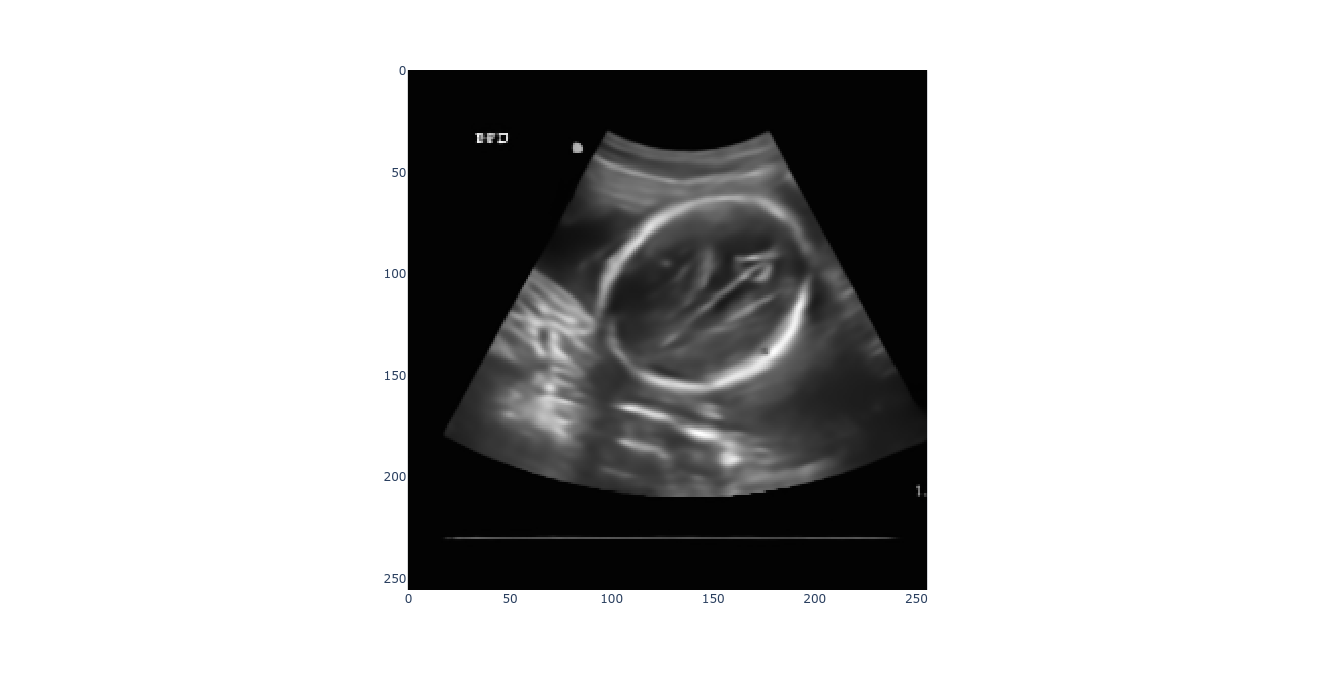

In [6]:
# ridx = np.random.randint(low=0, high=len(test_ds))
# print(ridx)
ridx = 1874762
z_mu, z_sigma = model.autoencoderkl.encode(test_ds[ridx].unsqueeze(dim=0).cuda())
z = model.autoencoderkl.sampling(z_mu, z_sigma)
reconstruction = model.autoencoderkl.decode(z)

fig = px.imshow(reconstruction.detach().cpu().numpy().squeeze(), binary_string=True, width=680, height=680)
fig.show()

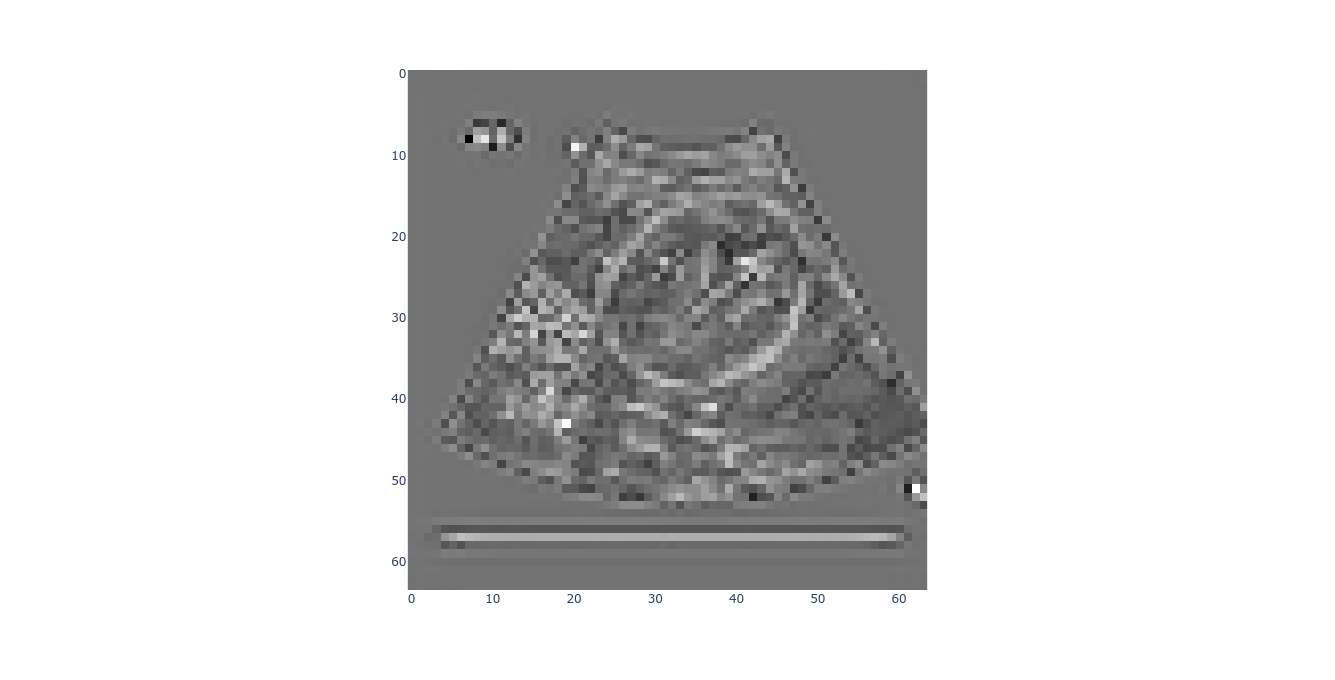

In [7]:
# h = model.autoencoderkl.encoder(test_ds[np.random.randint(low=0, high=len(test_ds))].unsqueeze(dim=0).cuda())
h = model.autoencoderkl.encoder(test_ds[ridx].unsqueeze(dim=0).cuda())
fig = px.imshow(h[0][2][:][:].detach().cpu().numpy(), binary_string=True, width=680, height=680)
fig.show()

In [25]:
csv_test = "CSV_files/MR_diffusion_test.csv"
df_test_mr = pd.read_csv(os.path.join(mount_point, csv_test))
nn = 'AutoEncoderKL'

NN = getattr(diffusion, nn)
model_mr = NN().load_from_checkpoint(os.path.join(mount_point, 'train_output/diffusion/mr_diffusion_v2.0/epoch=373-val_loss=0.01.ckpt'))

test_ds_mr = MRDatasetVolumes(df_test_mr, mount_point=mount_point, img_column="img_path", transform=MRDiffusionEvalTransforms(mount_point=mount_point, random_slice_size=1))

model_mr.cuda()


/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.

/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.



/mnt/raid/C1_ML_Analysis/


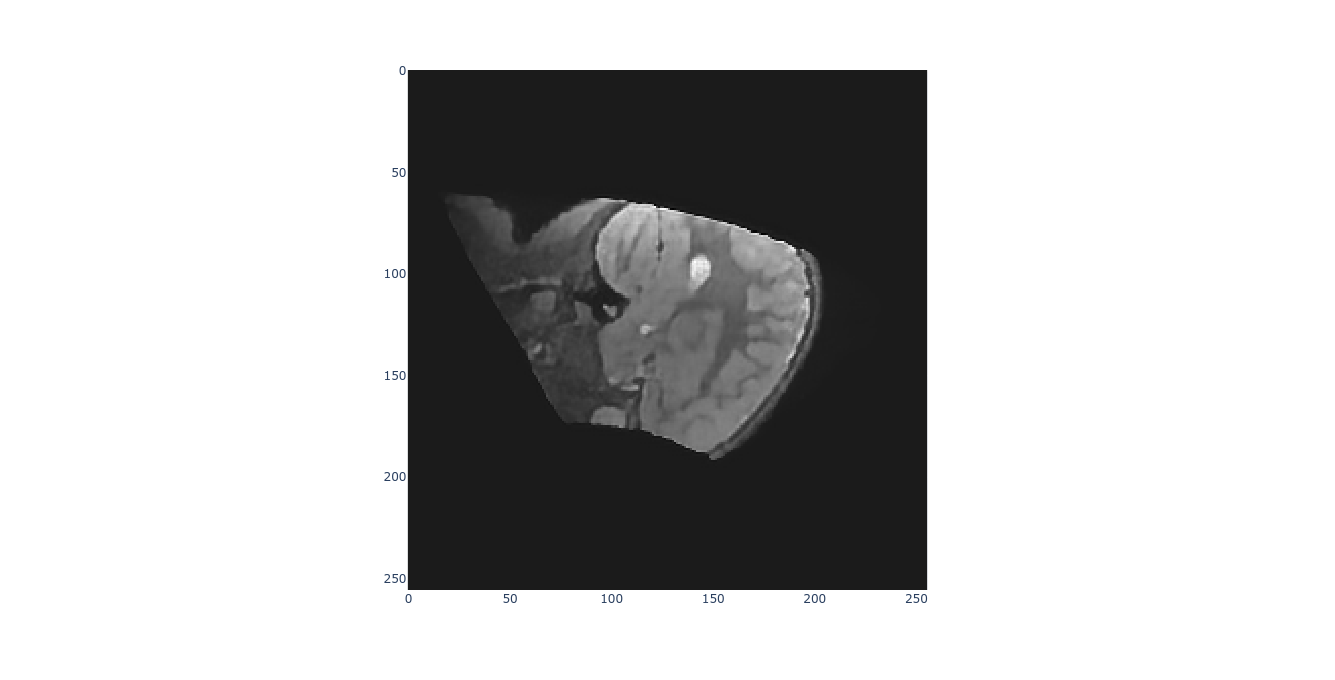

In [48]:
# ridx = np.random.randint(low=0, high=len(test_ds_mr))
# print(ridx)
ridx = 29

z_mu, z_sigma = model_mr.autoencoderkl.encode(test_ds_mr[ridx].cuda())
z = model_mr.autoencoderkl.sampling(z_mu, z_sigma)
reconstruction = model_mr.autoencoderkl.decode(z)

fig = px.imshow(reconstruction.detach().cpu().numpy().squeeze(), binary_string=True, width=680, height=680)
fig.show()

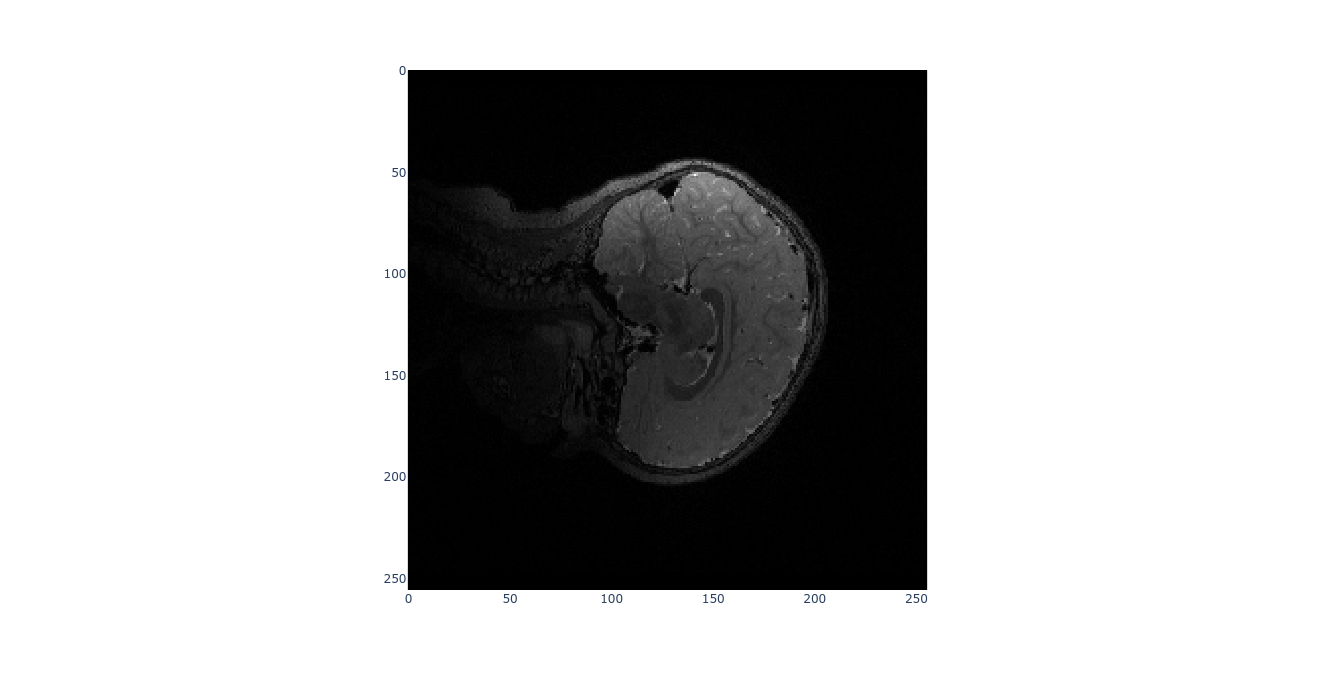

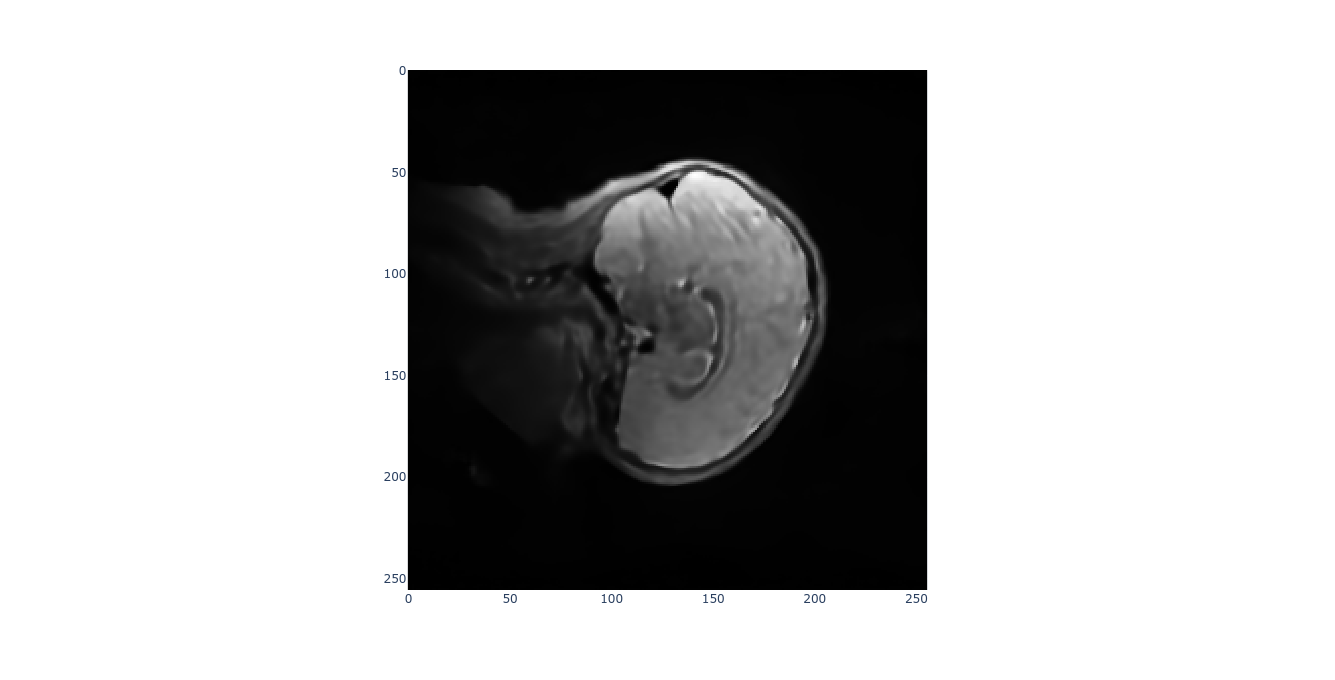

In [62]:
ridx = 29

img = test_ds_mr[ridx].cuda()
z_mu, z_sigma = model.autoencoderkl.encode(img)
z = model.autoencoderkl.sampling(z_mu, z_sigma)
reconstruction = model.autoencoderkl.decode(z)

fig = px.imshow(img.detach().cpu().numpy().squeeze(), binary_string=True, width=680, height=680)
fig.show()

fig2 = px.imshow(reconstruction.detach().cpu().numpy().squeeze(), binary_string=True, width=680, height=680)
fig2.show()

In [65]:
mu, s = model.autoencoderkl.encode(torch.rand(1, 1, 64, 64).cuda())

In [68]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

In [69]:
concat_ds = ConcatDataset(test_ds_mr, test_ds)

In [70]:
mr, us = concat_ds[0]

In [73]:
mr.shape

torch.Size([1, 1, 256, 256])

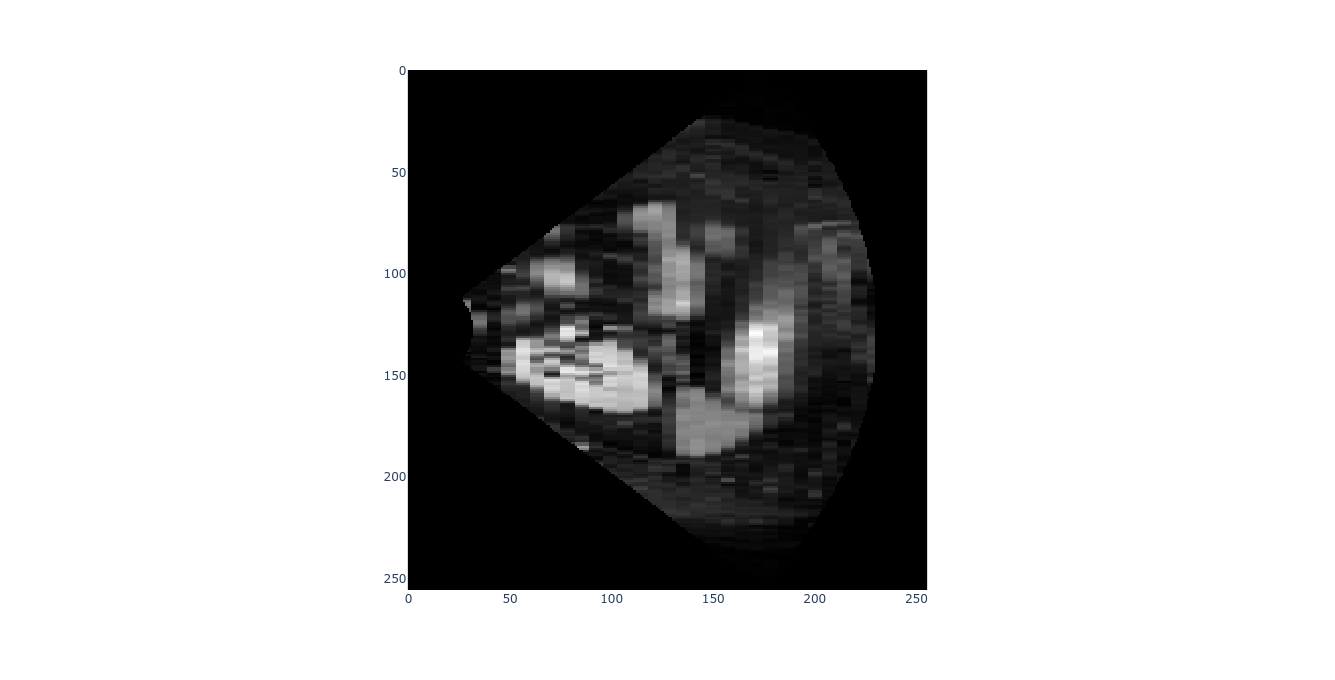

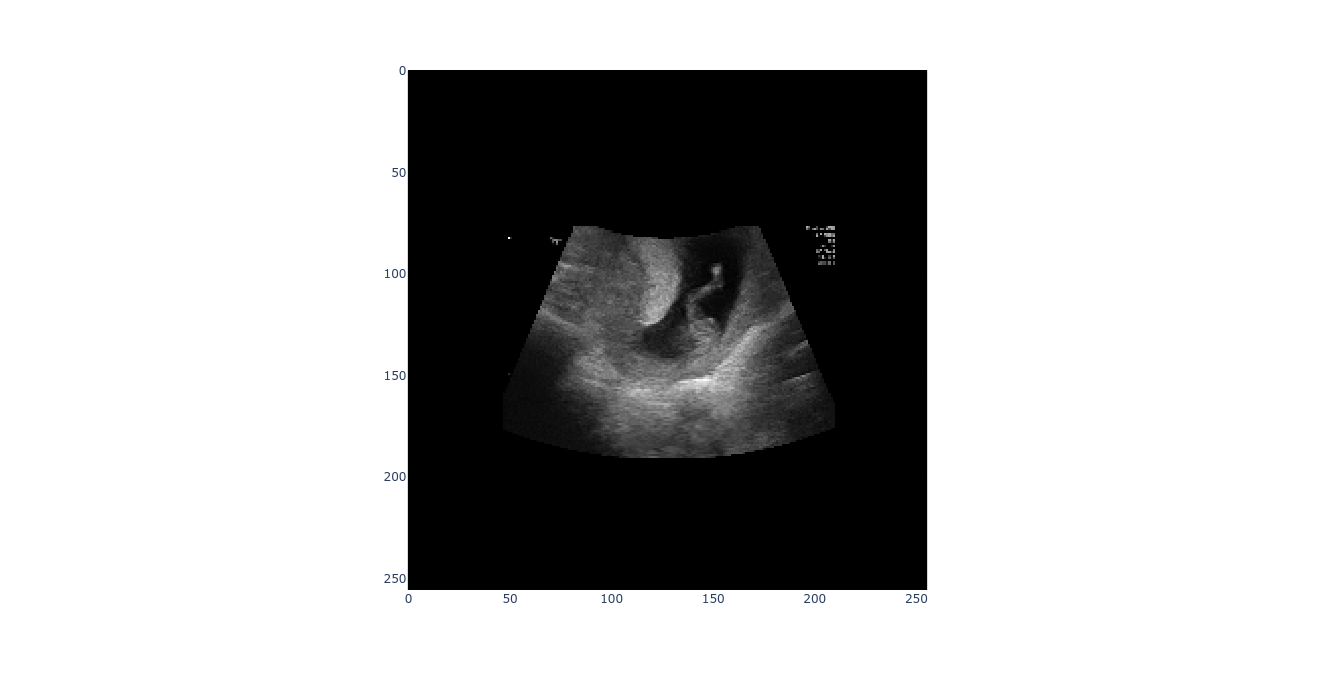

In [74]:

fig = px.imshow(mr.detach().cpu().numpy().squeeze(), binary_string=True, width=680, height=680)
fig.show()

fig2 = px.imshow(us.detach().cpu().numpy().squeeze(), binary_string=True, width=680, height=680)
fig2.show()

In [121]:
class GaussianNoise(torch.nn.Module):    
    def __init__(self, mean=0.0, std=0.05):
        super(GaussianNoise, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)
    def forward(self, x):
        if self.training:
            return x + torch.normal(mean=self.mean, std=self.std, size=x.size(), device=x.device)
        return x
    
class RandCoarseShuffle(torch.nn.Module):    
    def __init__(self, prob=0.75, holes=64, spatial_size=16):
        super(RandCoarseShuffle, self).__init__()
        self.t = monai_transforms.RandCoarseShuffle(prob=prob, holes=holes, spatial_size=spatial_size)
    def forward(self, x):
        if self.training:
            return self.t(x)
        return x

class SaltAndPepper(torch.nn.Module):    
    def __init__(self, prob=0.05):
        self.prob = prob
    def __call__(self, x):
        noise_tensor = torch.rand(x.shape)
        salt = torch.max(x)
        pepper = torch.min(x)
        x[noise_tensor < self.prob/2] = salt
        x[noise_tensor > 1-self.prob/2] = pepper
        return x
    
noise_transform = torch.nn.Sequential(
    GaussianNoise(0.0, 0.05),
    RandCoarseShuffle(),
    SaltAndPepper()
    
)

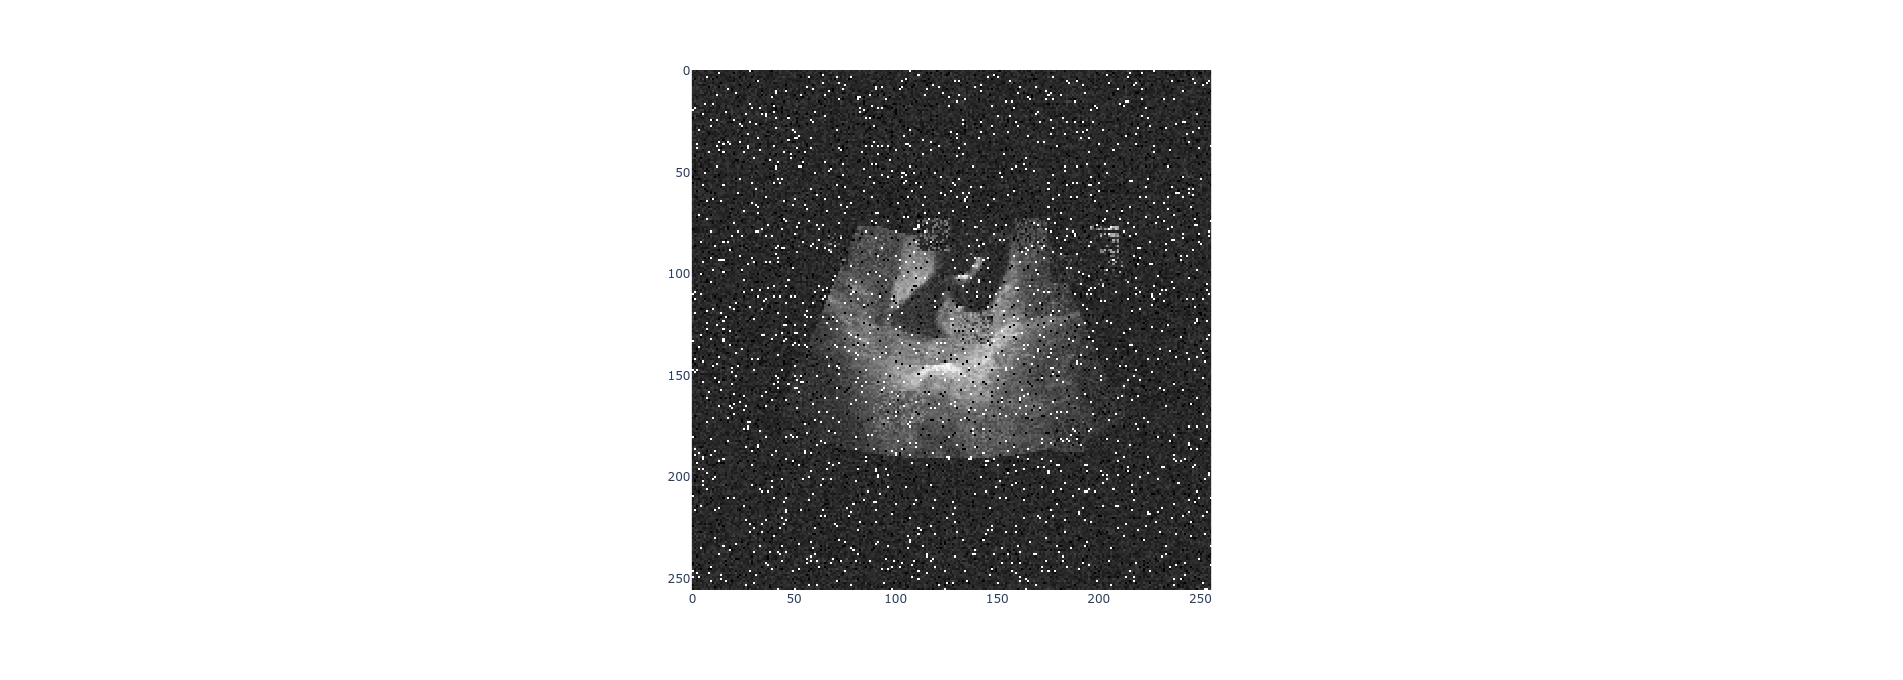

In [126]:
fig2 = px.imshow(noise_transform(test_ds[ridx]).detach().cpu().numpy().squeeze(), binary_string=True, width=680, height=680)
fig2.show()